In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [147]:
# Load the IMDB data
movie_data = pd.read_csv('movie_metadata.csv')
movie_data.columns.values

array(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_2_name', 'actor_1_facebook_likes', 'gross', 'genres',
       'actor_1_name', 'movie_title', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'aspect_ratio', 'movie_facebook_likes'], dtype=object)

In [148]:
# Data cleaning will be using imdb score and gross rev
# Drop rows with missing gross revenue data (standard practice in regression analysis)
movie_data = movie_data.dropna(subset = ['gross'])

# Only keep data on movies from US
movie_data = movie_data[movie_data['country'] == "USA"]

# Assuming a average US inflation rate of 2.5% convert gross revenue in terms of 2017 $
movie_data[['gross']] = (1.025**(2017 - movie_data['title_year']))*movie_data['gross']

movie_data = movie_data[['gross', 'imdb_score']]

# Let's scale the gross revenue to be in millions of dollars so its easier to read
movie_data[['gross']] = movie_data[['gross']]/1000000

movie_data.describe()

,gross,imdb_score
count,3235.000000,3235.000000
mean,79.764661,6.385533
std,109.842143,1.049178
min,0.001044,1.600000
25%,14.132349,5.800000
50%,44.210734,6.500000
75%,102.207258,7.100000
max,1363.206376,9.300000


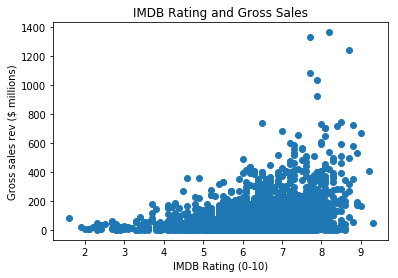

In [149]:
# Visualize data
plt.scatter(movie_data['imdb_score'], movie_data['gross'])
plt.title('IMDB Rating and Gross Sales')

plt.ylabel('Gross sales rev ($ millions)')

plt.xlabel('IMDB Rating (0-10)')

plt.show()

In [150]:
# Data size, this is the derivative with respect to B0^2
n = len(movie_data.index)

sum_imdb = sum(movie_data['imdb_score'])

sum_sq_imdb = sum(np.power(movie_data['imdb_score'], 2))

H = [[n, sum_imdb], [sum_imdb, sum_sq_imdb]]

epsilon = 10 ** -4

criterion = 10

new_param = np.array((-50, 10))

In [151]:
def newton_update(old_param, hessian, jacobian):
    new_param = np.array(np.subtract(old_param, np.dot(np.linalg.inv(hessian), jacobian)))
    return new_param

In [152]:
gross_rev = np.array(movie_data['gross'])

imdb_score = np.array(movie_data['imdb_score'])

while criterion > epsilon:
    old_param = new_param
    
    #Compute gradient vector
    J_pos0 = -1 * (np.nansum(gross_rev)-n*old_param[0]-old_param[1]*sum_imdb)
    J_pos1 = -1 * (np.nansum(gross_rev * imdb_score)-old_param[0]*sum_imdb-old_param[1]*sum_sq_imdb)
    J = np.array([J_pos0, J_pos1])
    
    # Apply newton's update rule
    new_param = newton_update(old_param, H, J)
    print(new_param)
    
    # Compute creterion function using euclidean distance
    criterion = np.linalg.norm(new_param-old_param)
    

[-113.36228051   30.2444501 ]
[-113.36228051   30.2444501 ]


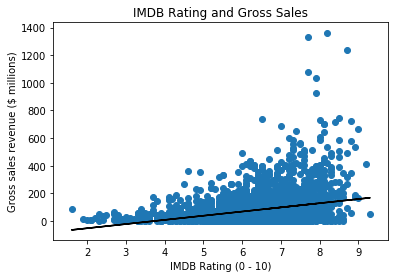

189.08222047986285


In [160]:
plt.plot(imdb_score, new_param[1]*imdb_score + new_param[0], '-k')

# Visualize data
plt.scatter(imdb_score, gross_rev)

# Chart title
plt.title('IMDB Rating and Gross Sales')

# y label
plt.ylabel('Gross sales revenue ($ millions)')

# x label
plt.xlabel('IMDB Rating (0 - 10)')

plt.show()


calculateRevForRating(10.0, new_param[1], new_param[0])

In [154]:
# normal linear regression from here
def compute_error_for_line_given_points(b, m, points):
    totalError = 0
    for i in range(0, len(points)):
        x = points[i, 0]
        y = points[i, 1]
        totalError += (y -(m*x + b)) ** 2
    return totalError/float(len(points))

In [155]:
def step_gradient(b_current, m_current, points, learningRate):
    b_gradient = 0
    m_gradient = 0
    N = float(len(points))
    for i in range(0, len(points)):
        x = points[i, 0]
        y = points[i, 1]
        b_gradient += -(2/N) * (y - ((m_current * x) + b_current))
        m_gradient += -(2/N) * x * (y - ((m_current * x) + b_current))
    new_b = b_current - (learningRate * b_gradient)
    new_m = m_current - (learningRate * m_gradient)
    return [new_b, new_m]

In [156]:
def gradient_descent_runner(points, starting_b, starting_m, learningRate, num_iterations):
    b = starting_b
    m = starting_m
    for i in range(num_iterations):
        b, m = step_gradient(b, m, np.array(points), learningRate)
        if i % 100 == 0:
            print('Iteration {0}, b:{1}, m:{2}, error:{3}'.format(i, b, m, compute_error_for_line_given_points(b, m, points)))
    return [b, m] 

In [157]:
points = movie_data.as_matrix(['imdb_score', 'gross'])
learningRate = 0.02
num_iterations = 5000
initial_b = 0
initial_m = 0
print('Starting gradient descent at b = {0}, m={1}, error={2}'.format(initial_b, initial_m, compute_error_for_line_given_points(initial_b, initial_m, points)))
print('Running')
[b, m] = gradient_descent_runner(points, initial_b, initial_m, learningRate, num_iterations)
print('After {0} iterations b = {1}, m = {2}, error = {3}'.format(num_iterations, b, m, compute_error_for_line_given_points(b, m, points)))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Starting gradient descent at b = 0, m=0, error=18423.96792152913
Running
Iteration 0, b:3.1905864252195837, m:21.704876103367187, error:14982.088159798002
Iteration 100, b:-9.437198641087685, m:14.38733087883985, error:11338.79593509229
Iteration 200, b:-19.58780523942947, m:15.936132920601855, error:11286.05984232879
Iteration 300, b:-28.746978273655795, m:17.333659832794385, error:11243.122369029135
Iteration 400, b:-37.01155338630023, m:18.594687012278442, error:11208.162884608786
Iteration 500, b:-44.468908055472106, m:19.732546708234366, error:11179.699040394944
Iteration 600, b:-51.19788539596915, m:20.759268977781744, error:11156.523915221762
Iteration 700, b:-57.26962773056708, m:21.685708874133805, error:11137.654839676105
Iteration 800, b:-62.7483287444459, m:22.521661211985755, error:11122.291729043973
Iteration 900, b:-67.69191217492835, m:23.275964123498763, error:11109.783158196222
Iteration 1000, b:-72.15264421199895, m:23.956592499727698, error:11099.598739923184
Iterat

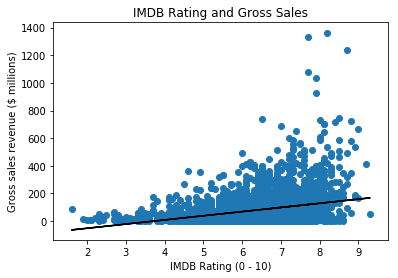

101.31697262450673


In [162]:
plt.plot(imdb_score, m*imdb_score + b, '-k')
plt.scatter(imdb_score, gross_rev)

# Chart title
plt.title('IMDB Rating and Gross Sales')

# y label
plt.ylabel('Gross sales revenue ($ millions)')

# x label
plt.xlabel('IMDB Rating (0 - 10)')

plt.show()


calculateRevForRating(7.1, m, b)
    